# COGS108 SP20 Individual_FinalProject

## Name & PID
Name : ZHENG Danyi 

PID : A16186734

## Overview

In this project, I analyzed the data provided to see what's the relationship between the restaurants' food safety level and their potential customers, hoping it can help the govenment to focus on the health inspections in areas with more vulnerable groups if necessary. However, the analysis results show that I may be wrong, there is no significant relationship between the potential customers of the restaurants and their food safety level.

## Research Question

What is the relationship between the restaurants' food safety level and their potential customers?

## Background & Prior Work

With the "Black Lives Matter" going on and the previous discrimination on Asian people my and my friends experienced a few months ago, I start to think about how the living situation of minority people is. The vulnerable groups' health problem should be at a higher priority, as they tend to suffer more and get less proper in-time treatment, compared to the privileges. Food safety should be a top concern, as it is involved in our everyday life, three times a day. It is known that in the low and middle income countries, the foodborne disease is a great problem[1], then how about the low income areas in America? Studies also show that there is a increased risk in food safety problem when an area haa more minority populations[2]. Using the data we have for one county, I would like to know what's the relationship between the restaurants food safety level and their potential customers. By looking into this, we can urge the governments to focus more on the low income areas, or those with a higher minority population, so that these people can have fewer food health problems, and this can also release the health burden for the whole county a little bit.

References (include links):

1) Delia Grace(2015), "Food Safety in Low and Middle Income Countries", https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4586623/

2) Beth Krietsch(2014), "Toxic chemicals can enter food through packaging. We made a list.", https://www.foodsafetynews.com/2014/11/food-safety-and-socioeconomic-status-is-there-a-link/

## Hypothesis

1. The lower the avarage income, the lower food safety levels*.
2. The higher minority population in an area, the lower food safety levels*.

*The food safety level will be determined by the health inspection score and the number of violations observed.

In the areas where potential customers have lower income, they tend to buy cheaper foods to save money. To meet their price expectation, the restaurants may purchase cheaper food material, fewer staff to maintain the dining environment to save costs, which may results in more potential food safety problems. In the areas with more minority people, the restaurants may tend to earn more by reducing the costs, and even there is any health problem caused, the minority customers may not successfully let the restaurants give any compensation, so the restaurants care less about the consequences of violating the food inspection rules.

## Data Sets

The data sets I used are below:
1. inspections: the results of the health inspections of the restaurants in the Wake county, including date of inspection, id of the results, the food safety score, the number of critical problems, etc. It has a total of 18466 observations, but I only used each restaurants' most recent inspection result.
2. violations: the violations observed during the health inspections each time in the Wake County, including the type of violation, the severity, etc. It has a total of 185721 observations, but I only keep each restaurants' most recent inspection result.
3. zipcodes: the information of people in each area, separated by zip codes, including the average household income, the poverty level, the non-white population percentage, etc. It has a total of 38 observations, representing 38 areas' information based on the zip codes.

## Data cleaning

### Preparations

#### Import packages

In [1]:
## Data Sets

# Imports - these are all the imports needed for the assignment
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

#### Import data

In [2]:
df_inspections = pd.read_csv("inspections.csv",dtype={'postalcode': object})
df_violations = pd.read_csv("violations.csv",dtype={'statecode': object})
df_zipcodes = pd.read_csv("zipcodes.csv",dtype={'zip': object})

In [3]:
df_inspections = df_inspections[['hsisid','name','city','days_from_open_date','facilitytype','description','inspection_num','score','num_critical','num_non_critical','critical','postalcode']]
df_inspections = df_inspections.rename({'postalcode':'zip'},axis = 'columns')

In [4]:
df_inspections = df_inspections.dropna(subset=['zip','hsisid'])
df_zipcodes = df_zipcodes.dropna(subset=['zip'])
df_violations = df_violations.dropna(subset=['hsisid'])

To have a better look, we need to clean up the data and merge them. As we have three different hypothesis, we will do them separately

### Cleaning up and merging data

As the zipcodes have different length, and we would like to separate only by the first five digits, we will standardize the zip code for all files first.

In [5]:
def standardized_zipcode(string) :
    string = string.lower()
    string = string.lower()
    
    output = string[:5]
    
    return output

In [6]:
df_inspections['zip'] = df_inspections['zip'].apply(standardized_zipcode)
df_zipcodes['zip'] = df_zipcodes['zip'].apply(standardized_zipcode)

#### Match the information of area by zipcodes to the restaurants

In [7]:
df_zipcodes.shape

(38, 8)

Convert the average income to log10, to better see the distribution.

In [8]:
df_zipcodes = df_zipcodes.assign(income10 = np.log10(df_zipcodes['per_capita_income_dollars']))

In [9]:
df_zipcodes.head()

,zip,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite,income10
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9,4.335077
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9,4.565411
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8,4.520339
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8,4.615234
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9,4.697796


There are multiple inspection result in the data sets, but we will keep the most recent result.

Choosing the most recent inspection result by the open date for "inspection" file.

In [10]:
df_inspections['count_max'] = df_inspections.groupby('hsisid')['days_from_open_date'].transform(max)
df_inspections = df_inspections[df_inspections['days_from_open_date'] == df_inspections['count_max']]

Choosing the most recent inspection result by the open date for "violations" file.

In [11]:
df_violations.head()

,X.objectid,hsisid,inspectdate,category,statecode,critical,questionno,violationcode,severity,shortdesc,inspectedby,comments,pointvalue,observationtype,violationtype,count,cdcriskfactor,cdcdataitem
0,2149,4092015279,2014-09-22T00:00:00.000Z,Chemical,".2653,.2657",Yes,26,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",Lucy Schrum,7-102.11; Priority Foundation - Found unlabele...,0,Out,R,NaN,NaN,NaN
1,2150,4092014572,2014-09-29T00:00:00.000Z,Chemical,".2653,.2657",Yes,26,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",Daryl Beasley,7-102.11; Priority Foundation; One sanitizer b...,0,Out,CDI,NaN,NaN,NaN
2,2151,4092015906,2014-10-01T00:00:00.000Z,Chemical,".2653,.2657",Yes,26,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",Lucy Schrum,7-102.11; Priority Foundation - Found an unlab...,1,Out,CDI,NaN,NaN,NaN
3,2152,4092013840,2014-10-08T00:00:00.000Z,Chemical,".2653,.2657",Yes,26,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",Lucy Schrum,7-102.11; Priority Foundation - Found unlabele...,0,Out,CDI,NaN,NaN,NaN
4,2153,4092021788,2014-10-09T00:00:00.000Z,Chemical,".2653,.2657",Yes,26,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",Lucy Schrum,7-102.11; Priority Foundation - Found one unla...,0,Out,CDI,NaN,NaN,NaN


##### Stanadardization of the inspection date

By looking into the data, the inspection take place once a year, so we will keep only the year for the inspection date.

In [12]:
def standardized_inspectdate(string) :
    string = string.lower()
    string = string.lower()
    
    output = string[:4]
    
    return output

Apply the function and keep the most recent inspection results

In [13]:
df_violations['inspectdate'] = df_violations['inspectdate'].apply(standardized_inspectdate)
df_violations['mostrecent'] = df_violations.groupby('hsisid')['inspectdate'].transform(max)
df_violations = df_violations[df_violations['inspectdate'] == df_violations['mostrecent']]
df_violations = df_violations.sort_values(by = ['hsisid'])
df_violations.shape

(48299, 19)

In [14]:
df_violations.head()

,X.objectid,hsisid,inspectdate,category,statecode,critical,questionno,violationcode,severity,shortdesc,inspectedby,comments,pointvalue,observationtype,violationtype,count,cdcriskfactor,cdcdataitem,mostrecent
150930,152377,4092010018,2016,Physical Facilities,".2654,.2655,.2656",No,52,5-501.16,Core,Garbage & refuse properly disposed; facilities...,Angela Myers,5-501.16; Handwashing Sinks lack trash can. If...,1,Out,R,NaN,NaN,NaN,2016
168520,170928,4092010018,2016,Prevention of Food Contamination,".2652,.2653,.2654,.2656,.2657",No,40,3-302.15,Core,Washing fruits & vegetables,Angela Myers,3-302.15; Unwashed Fruit is stored in two diff...,0,Out,NaN,NaN,NaN,NaN,2016
188305,659,4092010018,2016,Approved Source,".2653,.2655",Yes,12,3-203.12,Priority Foundation,"Required records available: shellstock tags, p...",Angela Myers,3-203.12; When the last shellstock is removed ...,0,In,NaN,NaN,Food from Unsafe Source,Records,2016
109095,112512,4092010018,2016,Protection from Contamination,".2653,.2654",Yes,13,3-302.11,Priority,Food separated & protected,Angela Myers,3-302.11; Priority; Inside of the seafood walk...,1,Out,NaN,NaN,Contaminated Equipment,Separation/Segregation/Protection,2016
34167,35416,4092010018,2016,Physical Facilities,".2654,.2655,.2656",No,53,6-501.11,Core,"Physical facilities installed, maintained & clean",Angela Myers,"6-501.11; Several Walls are damaged, not in go...",0,Out,NaN,NaN,NaN,NaN,2016


Count how many violations are observed in the most recent inspection, and save them as "countbyhsisid" dataframe

In [15]:
countbyhsisid = df_violations['hsisid'].value_counts(dropna=True, sort=True).to_frame()
countbyhsisid['index1'] = countbyhsisid.index
countbyhsisid.columns = (['violationcount','hsisid'])
countbyhsisid.shape

(4270, 2)

In [16]:
countbyhsisid.head()

,violationcount,hsisid
4092015939,118,4092015939
4092016852,76,4092016852
4092015453,74,4092015453
4092013892,69,4092013892
4092015279,68,4092015279


##### Merge the violation count to df_inspections

In [17]:
df_inspections = pd.merge(df_inspections, countbyhsisid,on = ['hsisid'])

##### Merge the area information by zip codes with df_inspections, save as "df"

In [18]:
df = pd.merge(df_inspections, df_zipcodes,on = ['zip'])
df.shape

(3015, 22)

##### Drop the columns we don't need and rename the columns for better view.

In [19]:
df = df.drop(columns=['name','critical','city', 'facilitytype','description','inspection_num','num_critical','num_non_critical','median_family_income_dollars','median_household_income_dollars','count_max'])
df = df.rename(columns={"days_from_open_date": "open_days", "per_capita_income_dollars": "capita_income", "percent_damilies_below_poverty_line":"poverty_percent", "percent_snap_benefits":"snap", "percent_supplemental_security_income":"SSI", "percent_nonwhite":"minority_percent"})
df = df.sort_values(by = ['hsisid']).reset_index()
df.head()

,index,hsisid,open_days,score,zip,violationcount,capita_income,poverty_percent,snap,SSI,minority_percent,income10
0,800,4092010024,9036,96.0,27607,11,26007,12.8,8.8,3.9,25.0,4.415090
1,2162,4092010031,9255,96.5,27604,4,25532,14.4,10.2,3.8,41.3,4.407085
2,1401,4092010035,8786,92.5,27511,5,33139,9.6,4.5,2.2,24.8,4.520339
3,2035,4092010037,9097,96.5,27591,6,24239,10.1,12.9,3.0,32.8,4.384515
4,2093,4092010046,9113,96.0,27604,9,25532,14.4,10.2,3.8,41.3,4.407085


## Data Visualization

First, we can have a look of the distribution for the average income, poverty population and minority population.

##### Distribution of average income among different areas

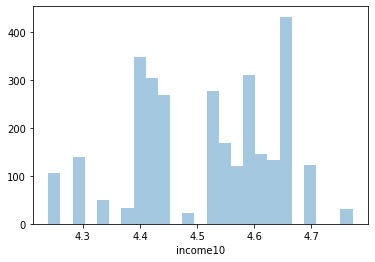

In [20]:
sns.distplot(df['income10'], kde = False, bins =25)

f1 = plt.gcf()

##### Distribution of poverty percent among different areas

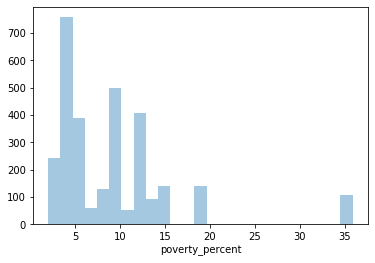

In [21]:
sns.distplot(df['poverty_percent'], kde = False, bins =25)

f2 = plt.gcf()

##### Distribution of minority percent among different areas

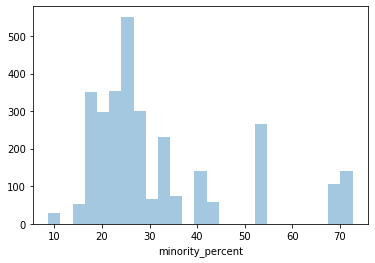

In [22]:
sns.distplot(df['minority_percent'], kde = False, bins =25)

f3 = plt.gcf()

It seems like we have some outliers, to better find out the relationship, we'd better get rid of some of the outliers when we try to analyze(in later steps).

In [23]:
df = df[df.income10 >= 4.5]
df = df[df.poverty_percent <= 20]
df = df[df.minority_percent <= 60]

Then let's try to find out the relationship between the customers and food safety level

##### The brief overview of the variables

In [24]:
desc = df.describe()
desc

,index,hsisid,open_days,score,violationcount,capita_income,poverty_percent,snap,SSI,minority_percent,income10
count,1742.000000,1.742000e+03,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000
mean,1507.409300,4.092031e+09,2990.578645,95.983065,10.384615,40559.344432,5.205913,4.327210,1.775545,25.468599,4.604163
std,886.125506,4.921415e+04,2595.808419,2.878224,8.877697,5530.213312,2.285864,2.007509,0.766726,9.999298,0.058141
min,0.000000,4.092010e+09,6.000000,72.500000,1.000000,33139.000000,2.000000,1.000000,0.500000,8.700000,4.520339
25%,911.250000,4.092015e+09,750.250000,94.500000,5.000000,34877.000000,3.600000,2.400000,1.300000,19.600000,4.542539
50%,1456.500000,4.092017e+09,2381.500000,96.500000,8.000000,39008.000000,4.200000,4.200000,1.600000,23.200000,4.591154
75%,2330.750000,4.092021e+09,4581.250000,98.000000,13.000000,44996.750000,5.500000,4.800000,2.200000,27.800000,4.653179
max,2879.000000,4.092300e+09,9316.000000,100.000000,76.000000,59155.000000,9.600000,9.000000,4.000000,53.300000,4.771991


##### The brief overview of relationship among the variables

In [25]:
corrs = df.corr()
corrs = corrs.loc[['score','violationcount'], ['hsisid', 'capita_income', 'poverty_percent', 'minority_percent','income10']]
corrs

,hsisid,capita_income,poverty_percent,minority_percent,income10
score,0.158458,0.008604,0.017000,-0.192776,0.009565
violationcount,-0.095031,-0.000077,-0.038962,0.097377,0.001469


It seems like there are almost no correlations among the variables we are interested in, let's have a deeper look.

### The relationship between customers and health inspection scores

##### Customers' average income vs. health inspection scores

In [26]:
a1, b1 = np.polyfit(df['income10'],df['score'], 1)
a1, b1

(0.47351623685733946, 93.80291964273034)

##### Percentage of poverty population vs. health inspection scores

In [27]:
a2, b2 = np.polyfit(df['poverty_percent'],df['score'], 1)
a2,b2

(0.021405276803389446, 95.87163143872144)

##### Percentage of minority population vs. health inspection scores

In [28]:
a3, b3 = np.polyfit(df['minority_percent'],df['score'], 1)
a3,b3

(-0.05548926933360103, 97.3962994087456)

##### Scatter plot with score on the y-axis and income on the x-axis

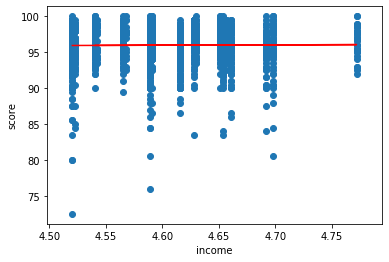

In [29]:
plt.scatter(df['income10'], df['score'])
m, b = np.polyfit(df['income10'], df['score'], 1)
plt.plot(df['income10'], m*df['income10'] + b, color = '#FF0000')
plt.xlabel('income')
plt.ylabel('score')

f4 = plt.gcf()

##### Scatter plot with score on the y-axis and poverty level on the x-axis

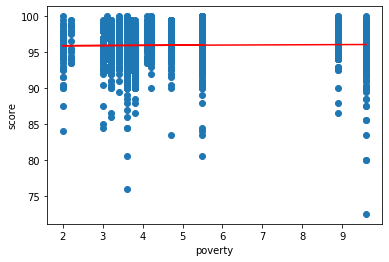

In [30]:
plt.scatter(df['poverty_percent'], df['score'])
m, b = np.polyfit(df['poverty_percent'], df['score'], 1)
plt.plot(df['poverty_percent'], m*df['poverty_percent'] + b, color = '#FF0000')
plt.xlabel('poverty')
plt.ylabel('score')

f5 = plt.gcf()

##### Scatter plot with score on the y-axis and minority level on the x-axis

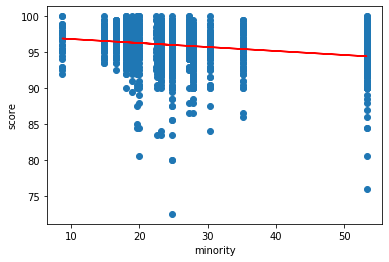

In [31]:
plt.scatter(df['minority_percent'], df['score'])
m, b = np.polyfit(df['minority_percent'], df['score'], 1)
plt.plot(df['minority_percent'], m*df['minority_percent'] + b, color = '#FF0000')
plt.xlabel('minority')
plt.ylabel('score')

f6 = plt.gcf()

### The relationship between customers and violation counts

##### Customers' average income vs. violation counts

In [32]:
a4, b4 = np.polyfit(df['income10'],df['violationcount'], 1)
a4, b4

(0.22426323053633132, 9.352070981842669)

##### Percentage of poverty population vs. violation counts

In [33]:
a5, b5 = np.polyfit(df['poverty_percent'],df['violationcount'], 1)
a5,b5

(-0.15131990054342465, 11.172373583271034)

##### Percentage of minority population vs. violation counts

In [34]:
a6, b6 = np.polyfit(df['minority_percent'],df['violationcount'], 1)
a6,b6

(0.08645405128116047, 8.182751793711027)

##### Scatter plot with violation count on the y-axis and income on the x-axis

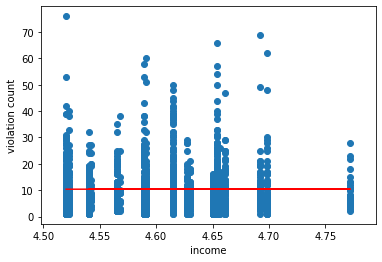

In [35]:
plt.scatter(df['income10'], df['violationcount'])
m, b = np.polyfit(df['income10'], df['violationcount'], 1)
plt.plot(df['income10'], m*df['income10'] + b, color = '#FF0000')
plt.xlabel('income')
plt.ylabel('violation count')

f7 = plt.gcf()

##### Scatter plot with violation count on the y-axis and poverty level on the x-axis

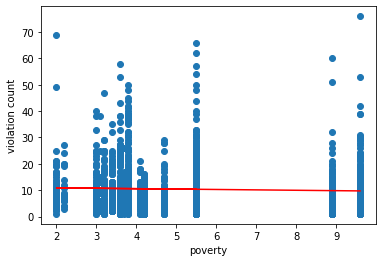

In [36]:
plt.scatter(df['poverty_percent'], df['violationcount'])
m, b = np.polyfit(df['poverty_percent'], df['violationcount'], 1)
plt.plot(df['poverty_percent'], m*df['poverty_percent'] + b, color = '#FF0000')
plt.xlabel('poverty')
plt.ylabel('violation count')

f8 = plt.gcf()

##### Scatter plot with violation count on the y-axis and minority level on the x-axis

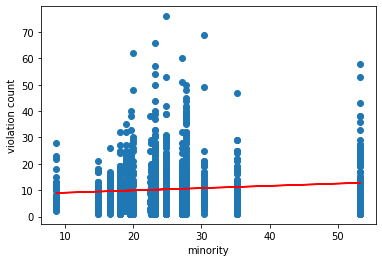

In [37]:
plt.scatter(df['minority_percent'], df['violationcount'])
m, b = np.polyfit(df['minority_percent'], df['violationcount'], 1)
plt.plot(df['minority_percent'], m*df['minority_percent'] + b, color = '#FF0000')
plt.xlabel('minority')
plt.ylabel('violation count')

f9 = plt.gcf()

## Data Analysis & Results

### OLS regression of health inspection score and the restaurants customers

##### OLS regression of health inspection score and customers' income

In [38]:
outcome_1, predictors_1 = patsy.dmatrices('score ~ income10', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1592
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.690
Time:                        17:27:45   Log-Likelihood:                -4312.8
No. Observations:                1742   AIC:                             8630.
Df Residuals:                    1740   BIC:                             8641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.8029      5.464     17.166      0.0

##### OLS regression of between health inspection score and Poverty level

In [39]:
outcome_2, predictors_2 = patsy.dmatrices('score ~ poverty_percent', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5030
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.478
Time:                        17:27:45   Log-Likelihood:                -4312.6
No. Observations:                1742   AIC:                             8629.
Df Residuals:                    1740   BIC:                             8640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          95.8716      0.172    5

##### OLS regression of between health inspection score and Minority level

In [40]:
outcome_3, predictors_3 = patsy.dmatrices('score ~ minority_percent', df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     67.16
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           4.80e-16
Time:                        17:27:45   Log-Likelihood:                -4279.9
No. Observations:                1742   AIC:                             8564.
Df Residuals:                    1740   BIC:                             8575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           97.3963      0.185  

### OLS regression of number of violations observed and the restaurants customers

##### OLS regression of violation counts and customers' income

In [41]:
outcome_4, predictors_4 = patsy.dmatrices('violationcount ~ income10', df)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.003753
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.951
Time:                        17:27:45   Log-Likelihood:                -6275.0
No. Observations:                1742   AIC:                         1.255e+04
Df Residuals:                    1740   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3521     16.855      0.555      0.5

##### OLS regression of between violation counts score and Poverty level

In [42]:
outcome_5, predictors_5 = patsy.dmatrices('violationcount ~ poverty_percent', df)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.645
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.104
Time:                        17:27:45   Log-Likelihood:                -6273.7
No. Observations:                1742   AIC:                         1.255e+04
Df Residuals:                    1740   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1724      0.529     

##### OLS regression of between violation counts score and Minority level

In [43]:
outcome_6, predictors_6 = patsy.dmatrices('violationcount ~ minority_percent', df)
mod_6 = sm.OLS(outcome_6, predictors_6)
res_6 = mod_5.fit()
print(res_6.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.645
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.104
Time:                        17:27:45   Log-Likelihood:                -6273.7
No. Observations:                1742   AIC:                         1.255e+04
Df Residuals:                    1740   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1724      0.529     

According to our analysis, the p-value of the previous 6 analysis are all very small (nearly 0, only one around 0.5), meaning that there are no significant correlations between either average income, poverty level or minority level with the health inspection score or the number of violations, in combination, the restaurants' food safety level.

Although when we look the scatter plot and linear regression result, the coefficient value between the average income and safety score is bigger than zero, meaning that there is a tiny positive relationship between the income and the safety score. And as the other two coefficient value is samller than zero, both poverty level and minority level are negatively related to the safety score. However, this is not consistent when we look into the relationship between those three factors with the number of violation observed.

To briefly conclude the result, we can't say that there is a linear relationship between customers' income, poverty level and minority level and the restaurants safety level. Key evidences shown above.

## Ethics & Privacy


As food safety is a concern to all residents, the data should be totally fair, fact-based, and unbiased. The food safety level of each restaurant should be visible to the every one, on their website and in-store. The feedbacks are always available to all customers. The information of each zipcode area is not based on single person, but a whole population, so no individual's privacy is violated. 
  
Despite the good intention, our analysis can bring harm and benefit to different stakeholders. Even though my results show that there is no significant relationship between the customers and the food safety level, the customers may still tend to choose the restaurants in the areas with less vulnerable groups, due to the tiny linear regression results. This could be unfair to the restaurants that are reasonably safety level in that area. I would like to draw the customers' attention that there is no relationship, so please choose whichever restaurant you like and is safe enough.

If the findings were consistent with my hypothesis, I would like to say that the government should take actions on both restaurants and customers. For the restaurants, the government should strengthen supervision on those with lower safety level, so that they can provide more healthy food. This may results in a higher cost, so the restaurants may increase the price, which is harder for the customers to afford. In this case, the government can give more supplemental security income and the snap benefit to the minority and low incomes.

Overall, whatever our findings are, our primary purpose is to improve food hygiene under a stronger restaurant inspection process, so that our residents enjoy healthier and safer food. No matter what 
incentive mechanisms used, the government should always promote and help the restaurants to improve food safety levels.

## Conclusion & Discussion

According to the above analysis, there is no significant relationship between the potential customers of the restaurants and their food safety level, although the tiny linear regression coefficient is what I expected. The data used was only from one county, which cannot represent the whole country, which was a limitation, and also, the score of inspections was not widely spreaded, which may not be easy to see the difference between a "better" restaurant and a "worse" one. Although I was proved wrong from what information I have, I would like to still call for more focus and care from the govenment to the vulnerable groups in the whole country, either they are under poverty level, black or yellow. They make up a large part of the U.S.population, and they deserve the same as everyone else.